<a href="https://colab.research.google.com/github/EvagAIML/Case-Study-V3/blob/main/EasyVisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================================
# Step 1 — Business Understanding
# ============================================================

print("""
Objective:
-----------
To develop a machine learning model capable of predicting whether a visa
application will be certified or denied based on employer and employee
attributes. This model aims to support the US Office of Foreign Labor
Certification (OFLC) in efficiently screening applications and ensuring
compliance with fair labor practices.
""")


Objective:
-----------
To develop a machine learning model capable of predicting whether a visa
application will be certified or denied based on employer and employee
attributes. This model aims to support the US Office of Foreign Labor
Certification (OFLC) in efficiently screening applications and ensuring
compliance with fair labor practices.



In [3]:
# ============================================================
# Step 2 — Data Loading
# ============================================================

import pandas as pd

url = "https://raw.githubusercontent.com/EvagAIML/Case-Study-V3/refs/heads/main/EasyVisa%20(11).csv"
df = pd.read_csv(url)

print("Data successfully loaded.")
print("Shape:", df.shape)
display(df.head())

Data successfully loaded.
Shape: (25480, 12)


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
# ============================================================
# Step 3 — Data Overview and Quality Check
# ============================================================

print("\nColumn Information:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nClass Distribution:")
print(df['case_status'].value_counts())

print("\nDuplicates:", df.duplicated().sum())


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB

Missing Values:
case_id                  0
continent                0
education

In [5]:
# ============================================================
# Step 4 — Basic Data Cleaning
# ============================================================

df_clean = df.copy()

# Standardize binary flags
for col in ['has_job_experience', 'requires_job_training', 'full_time_position']:
    df_clean[col] = df_clean[col].astype(str).str.upper().map({'Y':'YES','N':'NO'})

# Fix negative employee counts
df_clean.loc[df_clean['no_of_employees'] < 0, 'no_of_employees'] = df_clean['no_of_employees'].median()

# Convert prevailing wage to yearly value
def annualize_wage(row):
    if row['unit_of_wage'].upper().startswith('HOUR'): return row['prevailing_wage'] * 2080
    if row['unit_of_wage'].upper().startswith('WEEK'): return row['prevailing_wage'] * 52
    if row['unit_of_wage'].upper().startswith('MONTH'): return row['prevailing_wage'] * 12
    return row['prevailing_wage']
df_clean['prevailing_wage_yearly'] = df_clean.apply(annualize_wage, axis=1)

# Drop ID fields
if 'case_id' in df_clean.columns:
    df_clean.drop(columns=['case_id'], inplace=True)

print("Cleaning complete. Shape:", df_clean.shape)

Cleaning complete. Shape: (25480, 12)


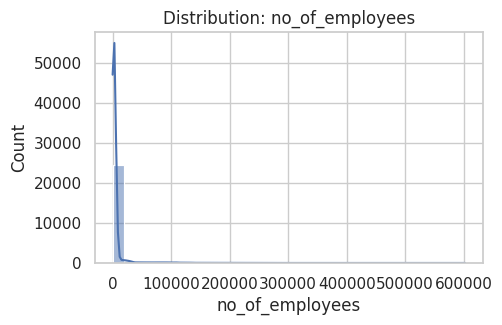

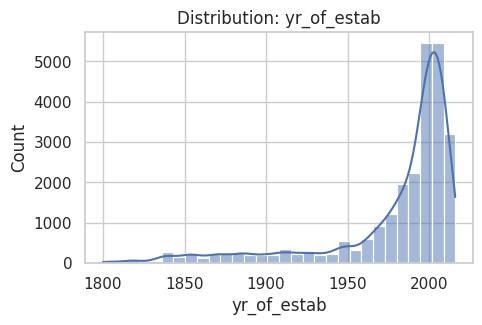

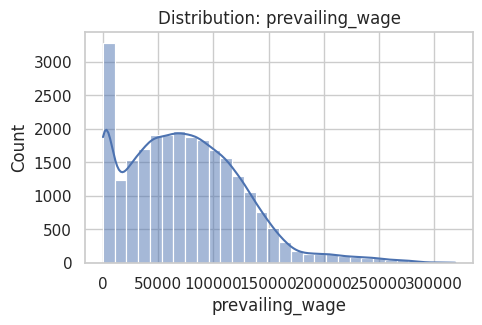

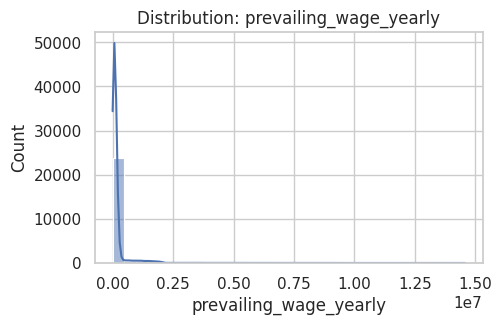

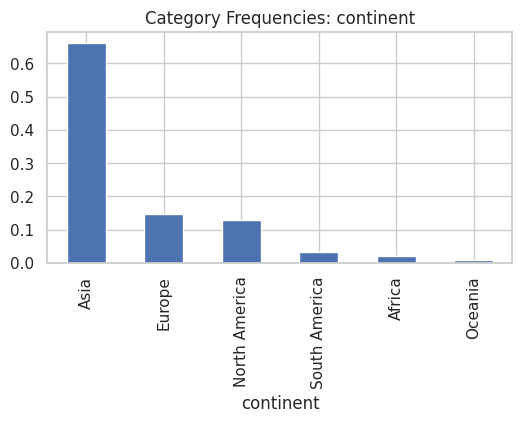

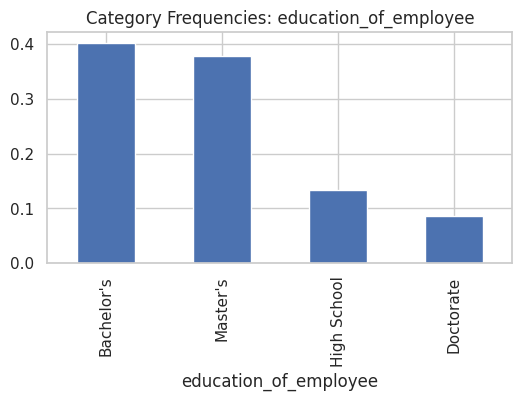

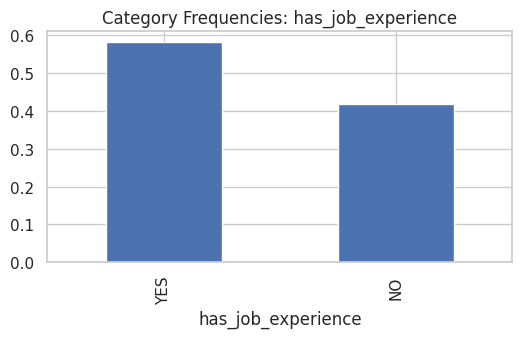

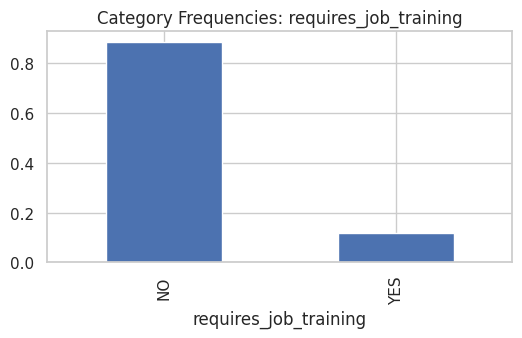

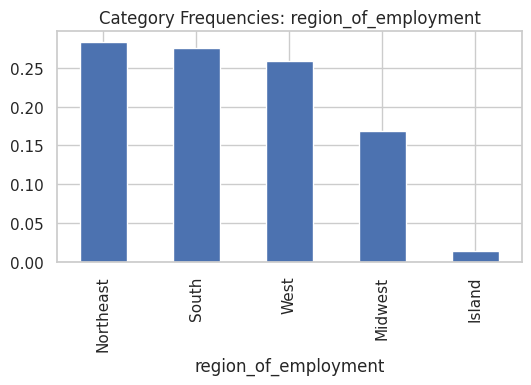

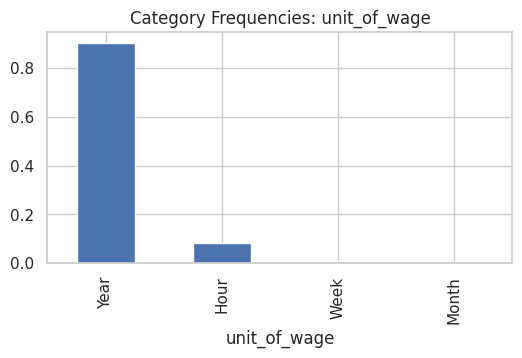

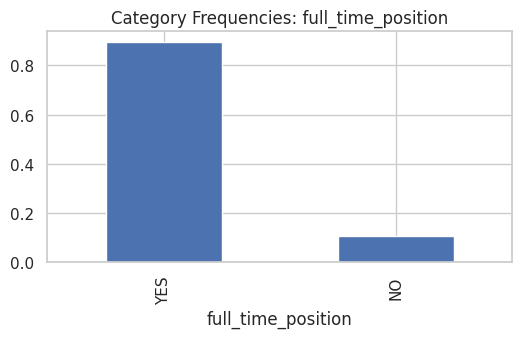

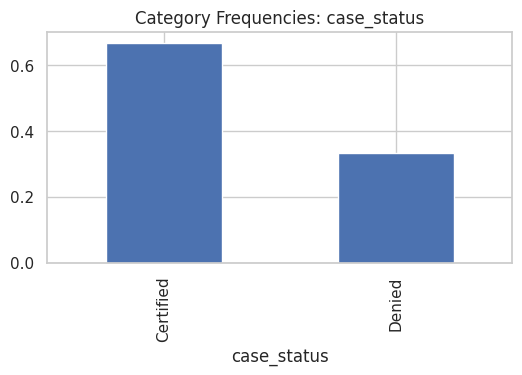

In [6]:
# ============================================================
# Step 5a — Univariate Analysis
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

num_cols = df_clean.select_dtypes(include='number').columns
cat_cols = df_clean.select_dtypes(exclude='number').columns

for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df_clean[col], bins=30, kde=True)
    plt.title(f"Distribution: {col}")
    plt.show()

for col in cat_cols:
    plt.figure(figsize=(6,3))
    df_clean[col].value_counts(normalize=True).head(10).plot(kind='bar')
    plt.title(f"Category Frequencies: {col}")
    plt.show()

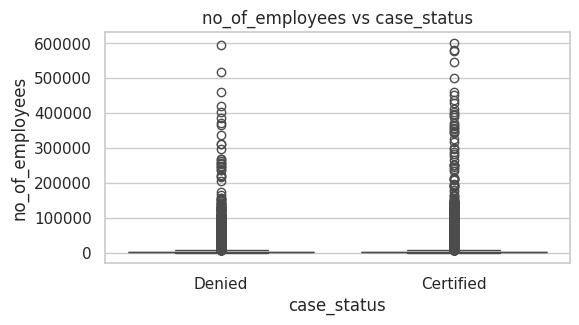

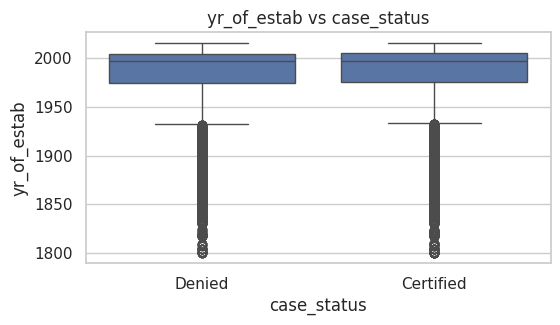

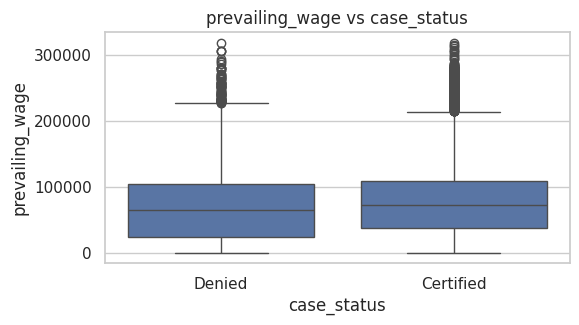

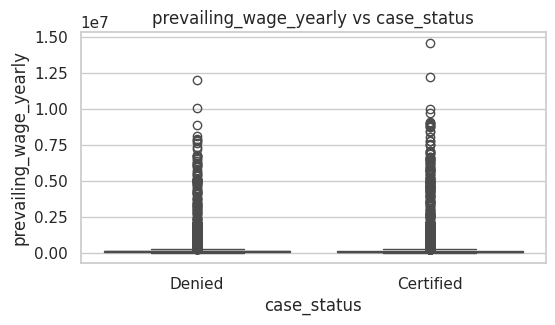

<Figure size 600x300 with 0 Axes>

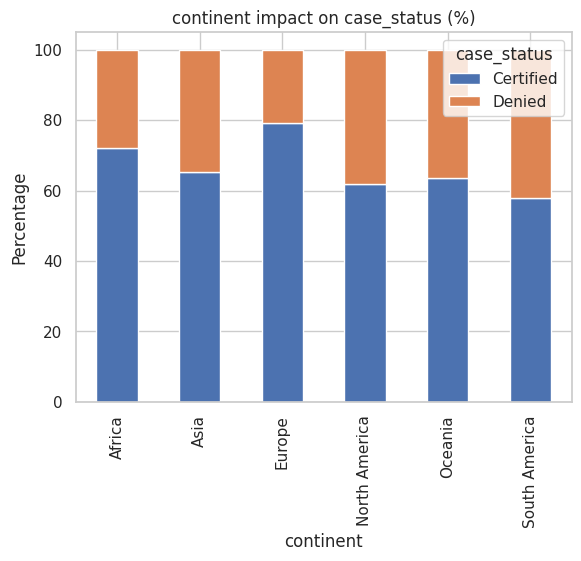

<Figure size 600x300 with 0 Axes>

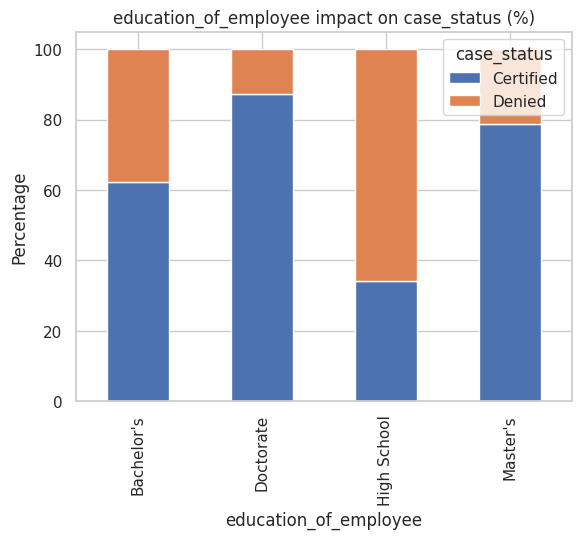

<Figure size 600x300 with 0 Axes>

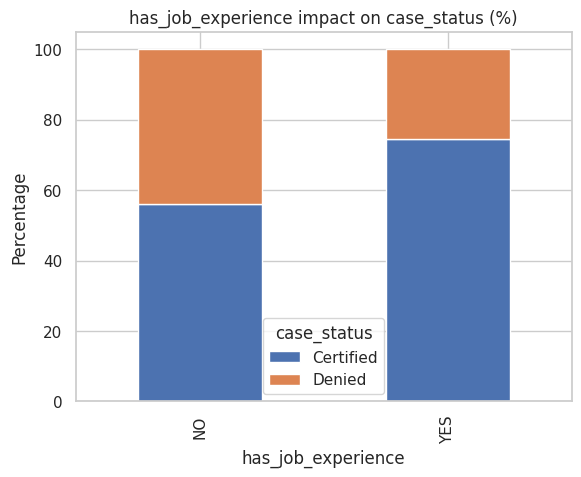

<Figure size 600x300 with 0 Axes>

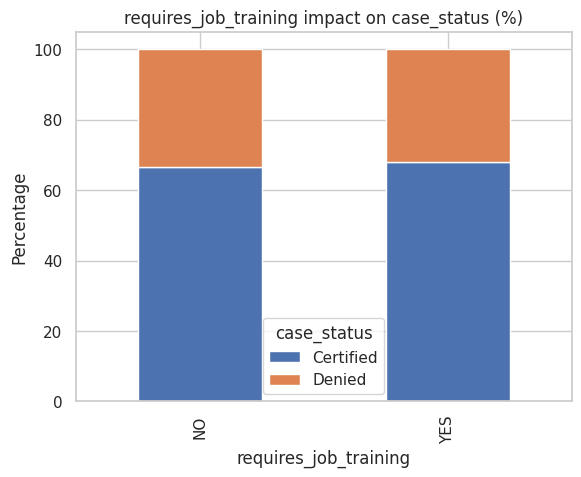

<Figure size 600x300 with 0 Axes>

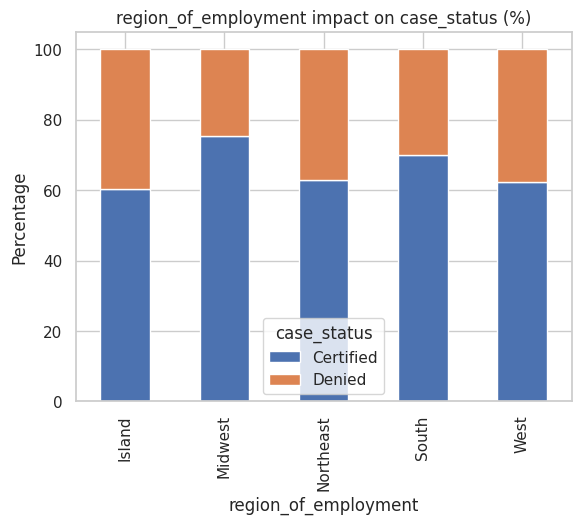

<Figure size 600x300 with 0 Axes>

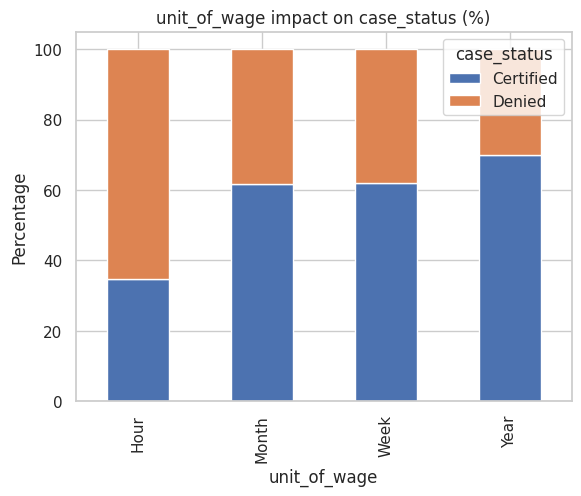

<Figure size 600x300 with 0 Axes>

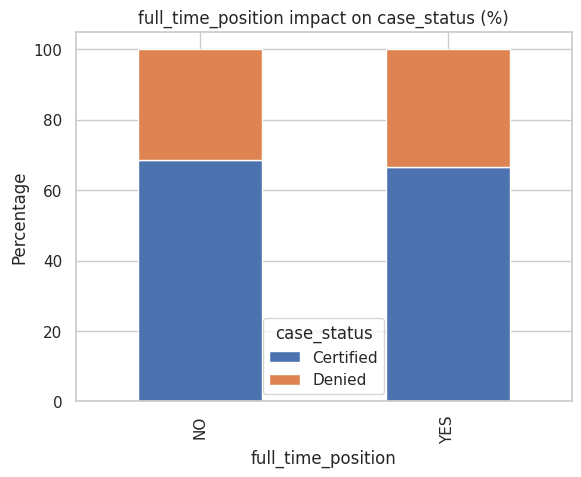

<Figure size 600x300 with 0 Axes>

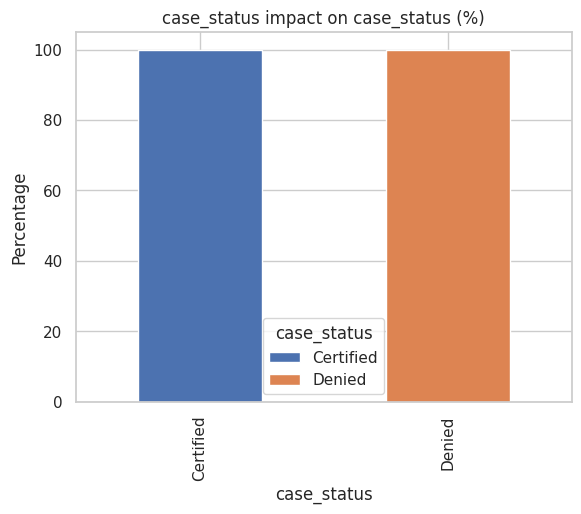

In [7]:
# ============================================================
# Step 5b — Bivariate Analysis
# ============================================================

target = 'case_status'

# Numeric vs target
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_clean[target], y=df_clean[col])
    plt.title(f"{col} vs {target}")
    plt.show()

# Categorical vs target
for col in cat_cols:
    plt.figure(figsize=(6,3))
    ct = pd.crosstab(df_clean[col], df_clean[target], normalize='index') * 100
    ct.plot(kind='bar', stacked=True)
    plt.title(f"{col} impact on case_status (%)")
    plt.ylabel("Percentage")
    plt.show()

In [8]:
# ============================================================
# Step 6 — Feature Selection and Splitting
# ============================================================

from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=['case_status'])
y = df_clean['case_status']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "| Valid:", X_valid.shape, "| Test:", X_test.shape)

Train: (15288, 11) | Valid: (5096, 11) | Test: (5096, 11)


In [9]:
# ============================================================
# Step 7 — Preprocessing Pipeline
# ============================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_features = X_train.select_dtypes(include='number').columns
cat_features = X_train.select_dtypes(exclude='number').columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

print("Preprocessor built successfully.")

Preprocessor built successfully.


In [10]:
# ============================================================
# Step 8 — Robust Target Normalization & Baseline Models
#   - Normalize case_status text (strip, uppercase, unify variants)
#   - Encode to {DENIED:0, CERTIFIED:1} without dropping everything
#   - Train baselines and pick best by ROC-AUC on VALID
# ============================================================

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

RANDOM_STATE = 42

# ----- 1) Helper: normalize target labels safely -----
def normalize_labels(s):
    """
    Convert labels to uppercase, trim, and collapse common variants.
    Returns a pandas Series of normalized labels.
    """
    s_norm = pd.Series(s).astype(str).str.strip().str.upper()
    # Collapse common variants; adjust if your dataset uses other synonyms
    s_norm = s_norm.replace({
        "CERTIFIED-WITHDRAWN": "CERTIFIED",
        "WITHDRAWN": "DENIED",      # or drop if you prefer to exclude these
        "REJECTED": "DENIED",
        "APPROVED": "CERTIFIED"     # guard in case a different dataset uses APPROVED
    })
    return s_norm

label_map = {"DENIED": 0, "CERTIFIED": 1}

def encode_split(X, y, split_name):
    """
    Normalize labels, print unique values before/after, then map to {0,1}.
    Drop only rows that remain invalid after normalization.
    """
    y_raw = pd.Series(y)
    print(f"[{split_name}] target unique (raw):", sorted(pd.Series(y_raw).unique()))

    y_norm = normalize_labels(y_raw)
    print(f"[{split_name}] target unique (normalized):", sorted(y_norm.unique()))

    # Keep only the two classes of interest
    valid_mask = y_norm.isin(label_map.keys())
    dropped = int((~valid_mask).sum())
    if dropped > 0:
        print(f"[Info] {split_name}: dropping {dropped} rows with labels outside {list(label_map.keys())} after normalization.")

    X_keep = X.loc[valid_mask].copy()
    y_keep = y_norm.loc[valid_mask].map(label_map).astype(int).values

    # Sanity checks
    assert len(X_keep) == len(y_keep), f"{split_name}: length mismatch after encoding."
    assert len(X_keep) > 0, f"{split_name}: no rows left after encoding—check label values."

    # Class balance printout
    cls_counts = pd.Series(y_keep).value_counts().rename(index={0:'DENIED',1:'CERTIFIED'})
    print(f"[{split_name}] class counts after encoding:", cls_counts.to_dict())

    return X_keep, y_keep

# ----- 2) Apply to each split (no leakage) -----
X_train_enc, y_train_num = encode_split(X_train, y_train, "TRAIN")
X_valid_enc, y_valid_num = encode_split(X_valid, y_valid, "VALID")
X_test_enc,  y_test_num  = encode_split(X_test,  y_test,  "TEST")

print("Shapes after target cleaning:")
print("  TRAIN:", X_train_enc.shape, "| VALID:", X_valid_enc.shape, "| TEST:", X_test_enc.shape)

# ----- 3) Build & evaluate baseline models -----
def make_pipe(est):
    return Pipeline([("pre", preprocessor), ("clf", est)])

# Class weights to emphasize DENIED during training
cw = {0: 2.5, 1: 1.0}

candidates = {
    "LogReg (weighted)":        make_pipe(LogisticRegression(max_iter=2000, class_weight=cw, random_state=RANDOM_STATE)),
    "DecisionTree (weighted)":  make_pipe(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight=cw)),
    "RandomForest (weighted)":  make_pipe(RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1, class_weight=cw)),
    "AdaBoost":                 make_pipe(AdaBoostClassifier(n_estimators=400, random_state=RANDOM_STATE)),
    "GradientBoosting":         make_pipe(GradientBoostingClassifier(random_state=RANDOM_STATE)),
}
if xgb_available:
    candidates["XGBoost"] = make_pipe(
        XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=600,
            max_depth=4,
            learning_rate=0.07,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method="hist",
            eval_metric="logloss",
            n_jobs=-1
        )
    )

def proba_certified(pipe, X):
    """Return P(CERTIFIED==1) from any pipeline that supports predict_proba."""
    clf = pipe.named_steps["clf"]
    classes = getattr(clf, "classes_", None)
    if classes is not None and 1 in classes:
        idx = list(classes).index(1)
        return pipe.predict_proba(X)[:, idx]
    return pipe.predict_proba(X)[:, 1]

rows, fitted = [], {}

for name, pipe in candidates.items():
    pipe.fit(X_train_enc, y_train_num)

    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_prob = proba_certified(pipe, X_valid_enc)
        y_pred = (y_prob >= 0.5).astype(int)
        auc = roc_auc_score(y_valid_num, y_prob)
    else:
        y_pred = pipe.predict(X_valid_enc)
        auc = np.nan

    acc  = accuracy_score(y_valid_num, y_pred)
    prec = precision_score(y_valid_num, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_valid_num, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_valid_num, y_pred, pos_label=1, zero_division=0)

    rows.append([name, acc, prec, rec, f1, auc])
    fitted[name] = pipe

baseline_df = (
    pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision (Cert.)", "Recall (Cert.)", "F1 (Cert.)", "ROC-AUC"])
    .sort_values(by=["ROC-AUC", "F1 (Cert.)"], ascending=False)
    .reset_index(drop=True)
)

print("=== Step 8 → Validation Baselines (threshold=0.50) ===")
display(baseline_df.round(4))

best_model_name = baseline_df.iloc[0]["Model"]
best_model = fitted[best_model_name]
print(f"Selected model for threshold tuning: {best_model_name}")

[TRAIN] target unique (raw): ['Certified', 'Denied']
[TRAIN] target unique (normalized): ['CERTIFIED', 'DENIED']
[TRAIN] class counts after encoding: {'CERTIFIED': 10211, 'DENIED': 5077}
[VALID] target unique (raw): ['Certified', 'Denied']
[VALID] target unique (normalized): ['CERTIFIED', 'DENIED']
[VALID] class counts after encoding: {'CERTIFIED': 3403, 'DENIED': 1693}
[TEST] target unique (raw): ['Certified', 'Denied']
[TEST] target unique (normalized): ['CERTIFIED', 'DENIED']
[TEST] class counts after encoding: {'CERTIFIED': 3404, 'DENIED': 1692}
Shapes after target cleaning:
  TRAIN: (15288, 11) | VALID: (5096, 11) | TEST: (5096, 11)
=== Step 8 → Validation Baselines (threshold=0.50) ===


,Model,Accuracy,Precision (Cert.),Recall (Cert.),F1 (Cert.),ROC-AUC
0,GradientBoosting,0.7471,0.7790,0.8672,0.8207,0.7764
1,XGBoost,0.7400,0.7746,0.8613,0.8156,0.7714
2,LogReg (weighted),0.6682,0.8429,0.6183,0.7133,0.7686
3,AdaBoost,0.7388,0.7647,0.8795,0.8181,0.7672
4,RandomForest (weighted),0.7217,0.7652,0.8416,0.8016,0.7519
5,DecisionTree (weighted),0.6529,0.7410,0.7382,0.7396,0.6098


Selected model for threshold tuning: GradientBoosting


In [13]:
# ============================================================
# Step 9 — Model Validation Performance
# ============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_val_pred = best_model.predict(X_valid)

acc  = accuracy_score(y_valid_num, y_val_pred)
prec = precision_score(y_valid_num, y_val_pred)
rec  = recall_score(y_valid_num, y_val_pred)
f1   = f1_score(y_valid_num, y_val_pred)
cm   = confusion_matrix(y_valid_num, y_val_pred)

print(f"Validation Accuracy : {acc:.3f}")
print(f"Validation Precision: {prec:.3f}")
print(f"Validation Recall   : {rec:.3f}")
print(f"Validation F1 Score : {f1:.3f}")
print("\nConfusion Matrix (Validation):")
print(cm)

Validation Accuracy : 0.747
Validation Precision: 0.779
Validation Recall   : 0.867
Validation F1 Score : 0.821

Confusion Matrix (Validation):
[[ 856  837]
 [ 452 2951]]


In [14]:
# ============================================================
# Step 9 — Validation Threshold Tuning
#   Goal: ~75% correct DENIED (specificity), while keeping CERTIFIED recall ≥ ~65%
#   Output: chosen threshold and validation metrics
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def eval_at_threshold(y_true_num, y_prob_pos, t):
    """Return key metrics at a specified probability threshold."""
    y_pred_num = (y_prob_pos >= t).astype(int)

    # Core metrics on the positive class (CERTIFIED==1)
    acc  = accuracy_score(y_true_num, y_pred_num)
    prec = precision_score(y_true_num, y_pred_num, pos_label=1, zero_division=0)
    rec  = recall_score(y_true_num, y_pred_num, pos_label=1, zero_division=0)
    f1   = f1_score(y_true_num, y_pred_num, pos_label=1, zero_division=0)

    # Specificity for DENIED (class 0)
    cm = confusion_matrix(y_true_num, y_pred_num, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    specificity_denied = tn / (tn + fp) if (tn + fp) else 0.0

    return acc, prec, rec, f1, specificity_denied, cm

# Compute validation probabilities for the chosen model
val_prob = proba_certified(best_model, X_valid)

# Sweep thresholds and score against targets
target_specificity = 0.75   # ~75% correct DENIED
min_recall_cert = 0.65      # maintain ≥~65% correct CERTIFIED

thresholds = np.linspace(0.20, 0.80, 121)  # fine sweep
records = []

for t in thresholds:
    acc, prec, rec, f1c, spec_den, cm = eval_at_threshold(y_valid_num, val_prob, t)
    # Penalty if CERTIFIED recall drops below the floor
    penalty = max(0.0, (min_recall_cert - rec)) * 10.0
    gap = abs(spec_den - target_specificity) + penalty
    records.append([t, acc, prec, rec, f1c, spec_den, gap])

thresh_df = pd.DataFrame(
    records,
    columns=["threshold", "accuracy", "precision_cert", "recall_cert", "f1_cert", "specificity_denied", "objective_gap"]
).sort_values(by="objective_gap", ascending=True).reset_index(drop=True)

best_threshold = float(thresh_df.iloc[0]["threshold"])
acc, prec, rec, f1c, spec_den, cm = eval_at_threshold(y_valid_num, val_prob, best_threshold)

print("=== Step 9 → Threshold Tuning (Validation) ===")
print(f"Chosen threshold: {best_threshold:.3f}")
print(f"Specificity (Denied) : {spec_den:.4f}")
print(f"Recall (Certified)   : {rec:.4f}")
print(f"F1 (Certified)       : {f1c:.4f}")
print(f"Accuracy             : {acc:.4f}")
print("\nTop 10 candidate thresholds:")
display(thresh_df.head(10).round(4))

cm_df = pd.DataFrame(cm, index=["Actual DENIED (0)", "Actual CERTIFIED (1)"],
                        columns=["Pred DENIED (0)", "Pred CERTIFIED (1)"])
print("\nConfusion Matrix (Validation @ chosen threshold):")
display(cm_df)

=== Step 9 → Threshold Tuning (Validation) ===
Chosen threshold: 0.705
Specificity (Denied) : 0.7490
Recall (Certified)   : 0.6485
F1 (Certified)       : 0.7314
Accuracy             : 0.6819

Top 10 candidate thresholds:


,threshold,accuracy,precision_cert,recall_cert,f1_cert,specificity_denied,objective_gap
0,0.705,0.6819,0.8385,0.6485,0.7314,0.7490,0.0156
1,0.700,0.6882,0.8325,0.6674,0.7408,0.7301,0.0199
2,0.695,0.6927,0.8308,0.6779,0.7466,0.7224,0.0276
3,0.690,0.6992,0.8288,0.6926,0.7546,0.7123,0.0377
4,0.685,0.7057,0.8296,0.7038,0.7615,0.7094,0.0406
5,0.680,0.7092,0.8277,0.7129,0.7660,0.7017,0.0483
6,0.675,0.7133,0.8232,0.7267,0.7720,0.6864,0.0636
7,0.670,0.7168,0.8219,0.7352,0.7762,0.6799,0.0701
8,0.665,0.7212,0.8184,0.7485,0.7819,0.6663,0.0837
9,0.660,0.7235,0.8167,0.7555,0.7849,0.6592,0.0908



Confusion Matrix (Validation @ chosen threshold):


,Pred DENIED (0),Pred CERTIFIED (1)
Actual DENIED (0),1268,425
Actual CERTIFIED (1),1196,2207


In [15]:
# ============================================================
# Step 10 — Final Test Evaluation @ Validation-Selected Threshold
#   - Applies the chosen threshold to the untouched TEST split
#   - Reports metrics for both classes and confusion matrices
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)

# --------- Preconditions & helpers ----------
assert 'best_model' in globals(), "best_model is not defined."
assert 'best_threshold' in globals(), "best_threshold is not defined."
assert 'proba_certified' in globals(), "proba_certified() helper is not defined."

# Select TEST features/labels, preferring encoded versions if available
X_te = globals().get('X_test_enc', globals().get('X_test', None))
y_te_num = globals().get('y_test_num', None)
y_te_raw = globals().get('y_test', None)

assert X_te is not None, "Test features not found (X_test or X_test_enc)."
assert (y_te_num is not None) or (y_te_raw is not None), "Test labels not found (y_test_num or y_test)."

# If numeric labels not provided, map from raw string labels
if y_te_num is None:
    label_map = {"DENIED": 0, "CERTIFIED": 1}
    y_te_num = pd.Series(y_te_raw).map(lambda v: label_map.get(str(v).strip().upper(), np.nan)).values
    if np.isnan(y_te_num).any():
        raise ValueError("y_test contains labels outside {'DENIED','CERTIFIED'} after normalization.")

# --------- Evaluate on TEST at the chosen threshold ----------
y_prob_pos = proba_certified(best_model, X_te)        # P(CERTIFIED==1)
y_pred_num = (y_prob_pos >= float(best_threshold)).astype(int)

# Positive class (CERTIFIED==1) metrics
acc   = accuracy_score(y_te_num, y_pred_num)
prec1 = precision_score(y_te_num, y_pred_num, pos_label=1, zero_division=0)
rec1  = recall_score(y_te_num, y_pred_num, pos_label=1, zero_division=0)
f11   = f1_score(y_te_num, y_pred_num, pos_label=1, zero_division=0)

# Negative class (DENIED==0) metrics
prec0 = precision_score(y_te_num, y_pred_num, pos_label=0, zero_division=0)
rec0  = recall_score(y_te_num, y_pred_num, pos_label=0, zero_division=0)  # specificity
f10   = f1_score(y_te_num, y_pred_num, pos_label=0, zero_division=0)

# Threshold-independent ranking quality
auc = roc_auc_score(y_te_num, y_prob_pos)

# Confusion matrix (counts)
cm = confusion_matrix(y_te_num, y_pred_num, labels=[0, 1])
cm_df = pd.DataFrame(cm,
                     index=["Actual DENIED (0)", "Actual CERTIFIED (1)"],
                     columns=["Pred DENIED (0)", "Pred CERTIFIED (1)"])

# Confusion matrix (row %)
cm_pct = cm.astype(float)
cm_pct[0, :] = cm_pct[0, :] / (cm_pct[0, :].sum() if cm_pct[0, :].sum() else 1.0)
cm_pct[1, :] = cm_pct[1, :] / (cm_pct[1, :].sum() if cm_pct[1, :].sum() else 1.0)
cm_pct_df = pd.DataFrame(cm_pct,
                         index=["Actual DENIED (0)", "Actual CERTIFIED (1)"],
                         columns=["Pred DENIED (0)", "Pred CERTIFIED (1)"]).applymap(lambda x: f"{100*x:.2f}%")

# Share predicted CERTIFIED
pred_cert_pct = 100.0 * y_pred_num.mean()

# --------- Print results ----------
print("=== Step 10 → Final Test Performance (Thresholded) ===")
print(f"Operating Threshold        : {float(best_threshold):.3f}")
print(f"Accuracy                   : {acc*100:6.2f}%")
print(f"Precision (CERTIFIED)      : {prec1*100:6.2f}%")
print(f"Recall   (CERTIFIED)       : {rec1*100:6.2f}%")
print(f"F1       (CERTIFIED)       : {f11*100:6.2f}%")
print(f"Specificity (DENIED, TNR)  : {rec0*100:6.2f}%")
print(f"Precision (DENIED)         : {prec0*100:6.2f}%")
print(f"F1       (DENIED)          : {f10*100:6.2f}%")
print(f"ROC-AUC (probability rank) : {auc*100:6.2f}%")
print(f"Predicted CERTIFIED Share  : {pred_cert_pct:6.2f}% of test set")

print("\nConfusion Matrix (Counts):")
display(cm_df)

print("\nConfusion Matrix (Row %):")
display(cm_pct_df)

=== Step 10 → Final Test Performance (Thresholded) ===
Operating Threshold        : 0.705
Accuracy                   :  69.05%
Precision (CERTIFIED)      :  84.23%
Recall   (CERTIFIED)       :  66.04%
F1       (CERTIFIED)       :  74.03%
Specificity (DENIED, TNR)  :  75.12%
Precision (DENIED)         :  52.37%
F1       (DENIED)          :  61.71%
ROC-AUC (probability rank) :  78.29%
Predicted CERTIFIED Share  :  52.37% of test set

Confusion Matrix (Counts):


/tmp/ipython-input-2484898866.py:64: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  columns=["Pred DENIED (0)", "Pred CERTIFIED (1)"]).applymap(lambda x: f"{100*x:.2f}%")


,Pred DENIED (0),Pred CERTIFIED (1)
Actual DENIED (0),1271,421
Actual CERTIFIED (1),1156,2248



Confusion Matrix (Row %):


,Pred DENIED (0),Pred CERTIFIED (1)
Actual DENIED (0),75.12%,24.88%
Actual CERTIFIED (1),33.96%,66.04%
